In [1]:
from functools import lru_cache
import torch, torchvision
import matplotlib.pyplot as plt
import numpy as np
import math

from torch_fouriermellin.transform import RigidTransform


image = torchvision.io.read_image('public/mandrill.png')/255.
image = torchvision.transforms.functional.resize(image, [1024, 1024])
N=15
bimage = image.unsqueeze(0).expand(N,-1,-1,-1)
gtScale = torch.rand(N)+0.55
gtAngle = torch.randint(-89, 89, (N,)).float()
gtTransX = (150*(torch.rand(N)*2-1)).int()
gtTransY = (150*(torch.rand(N)*2-1)).int()
bimageTransf = RigidTransform(gtScale, gtTransX, gtTransY, gtAngle)(bimage)

In [2]:
from torch_fouriermellin.registration import MellinFourierRegistration

IM_SIZE = bimage.shape[-2:]
mf = MellinFourierRegistration(*IM_SIZE)
ans = mf.register_image(bimage, bimageTransf)
imageTransfRegistered = ans['registered']


ijPred = mf.get_translations(ans["params"]["pcTranslat"])
ijGTruth = torch.stack([gtTransY, gtTransX], dim=-1)




0


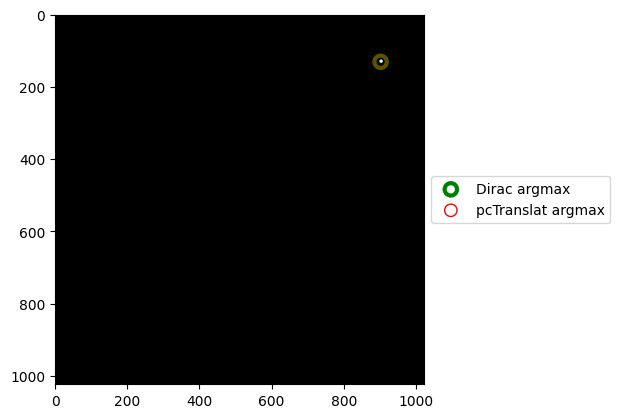

1


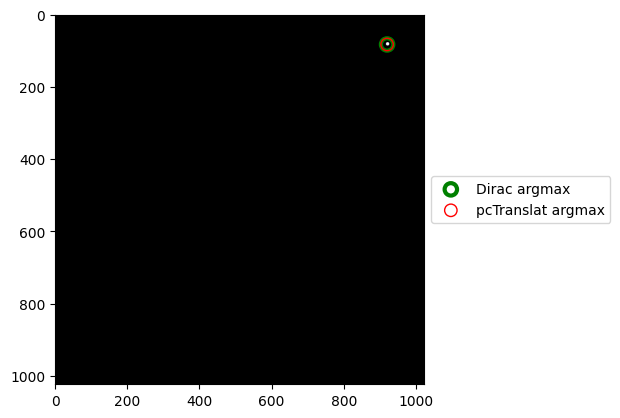

2


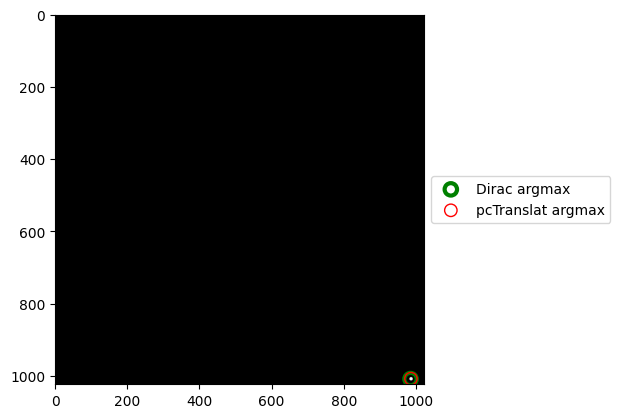

3


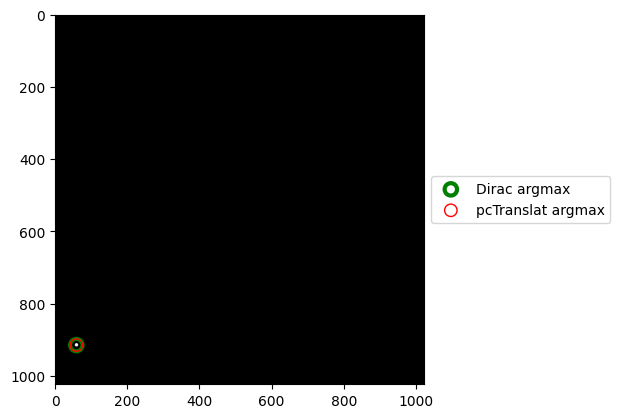

4


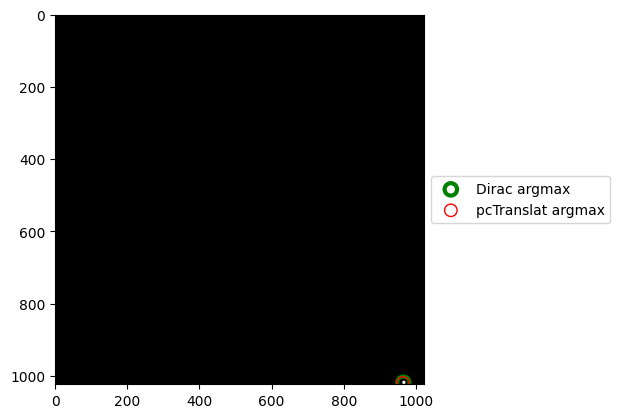

5


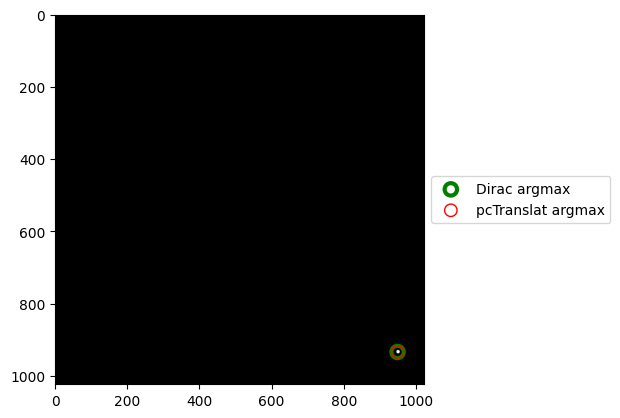

6


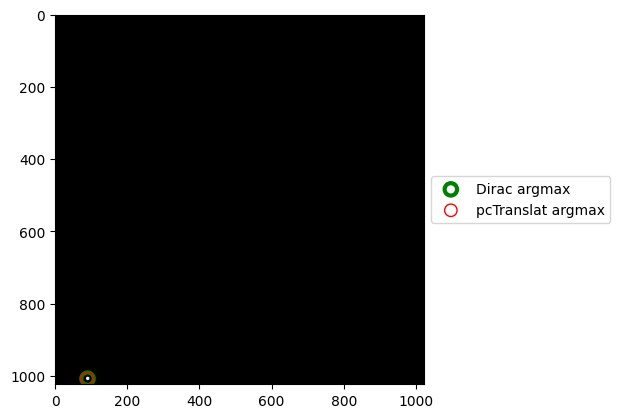

7


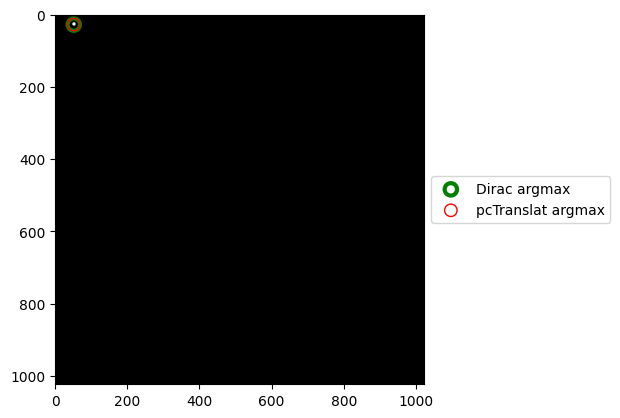

8


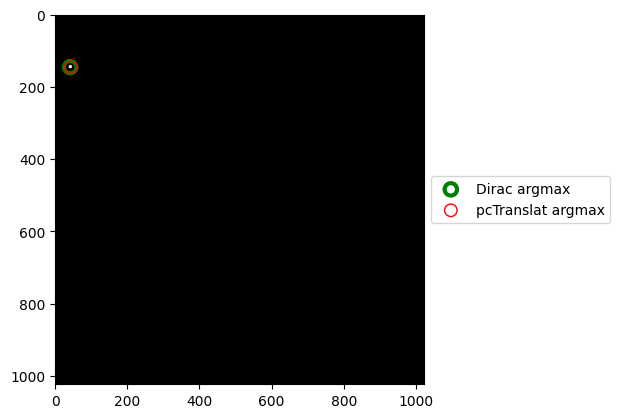

9


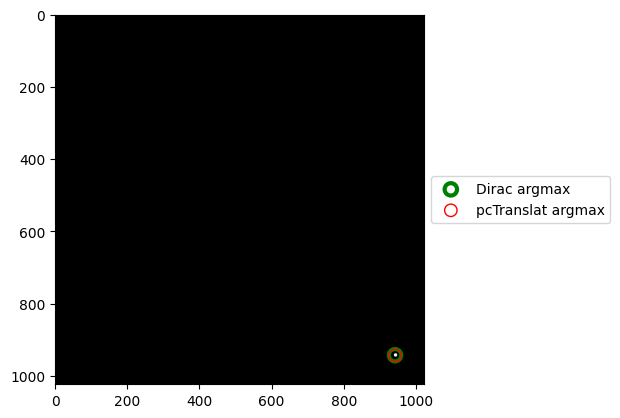

10


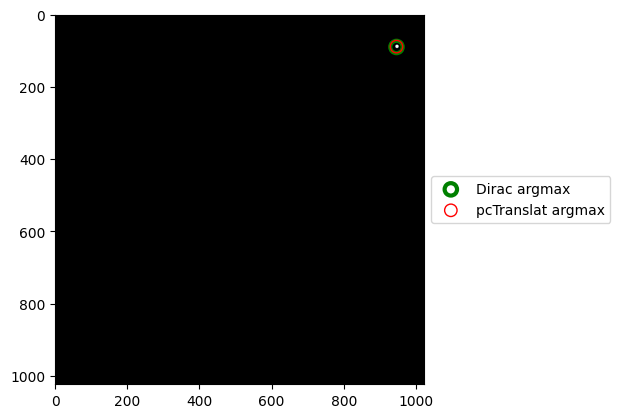

11


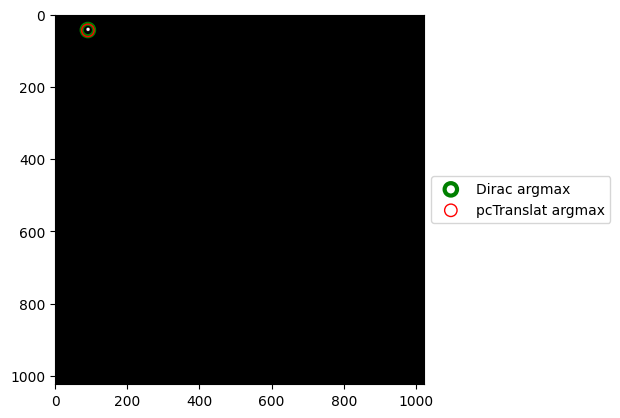

12


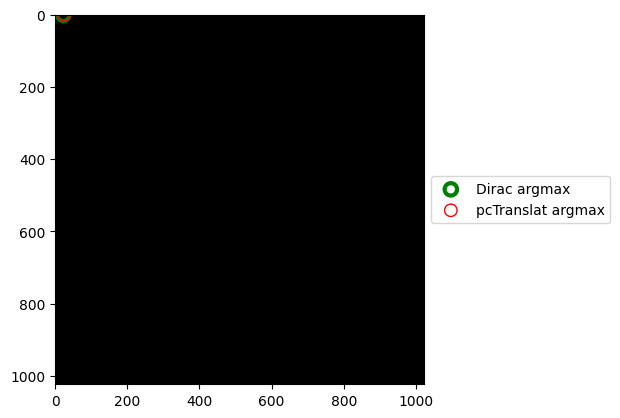

13


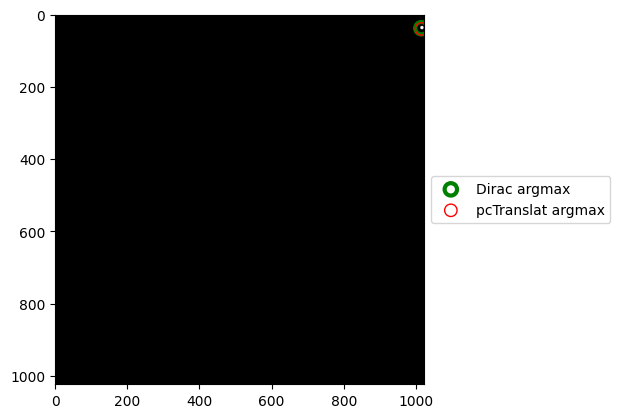

14


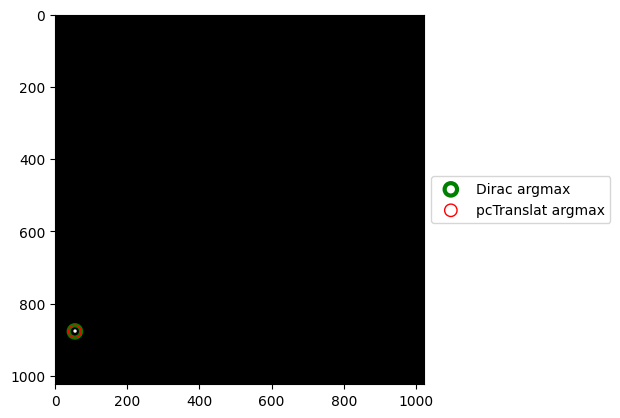

In [3]:
import numpy as np
import matplotlib.pyplot as plt

for b in range(ijPred.shape[0]):
    print(b)
    # Arrays
    arr1 = mf.get_translation_dirac(*IM_SIZE, ijGTruth[:,1], ijGTruth[:,0])[b]
    mask = mf.get_translation_disk(*IM_SIZE, ijGTruth[:,1], ijGTruth[:,0],5)[b]

    arr2 = ans["params"]["pcTranslat"][b].sum(0)
    
    
    y1, x1 = np.unravel_index(np.argmax(arr1), arr1.shape)
    y2, x2 = np.unravel_index(np.argmax(arr2), arr2.shape)
    plt.imshow(255*mask, cmap="gray")   # background
    # print((255*arr3).aminmax())
    plt.scatter(x1, y1, s=80, facecolors='none', edgecolors='g', linewidths=3, label="Dirac argmax")
    plt.scatter(x2, y2, s=80, facecolors='none', edgecolors='r', linewidths=1, label="pcTranslat argmax")  # thicker

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


In [4]:
mf.get_parameters_domain()

{'tyRange': torch.return_types.aminmax(
 min=tensor(-512),
 max=tensor(511)),
 'txRange': torch.return_types.aminmax(
 min=tensor(-512),
 max=tensor(511)),
 'rotRange': torch.return_types.aminmax(
 min=tensor(-89.5028),
 max=tensor(90.)),
 'scaleRange': torch.return_types.aminmax(
 min=tensor(0.0375),
 max=tensor(26.9072))}

0


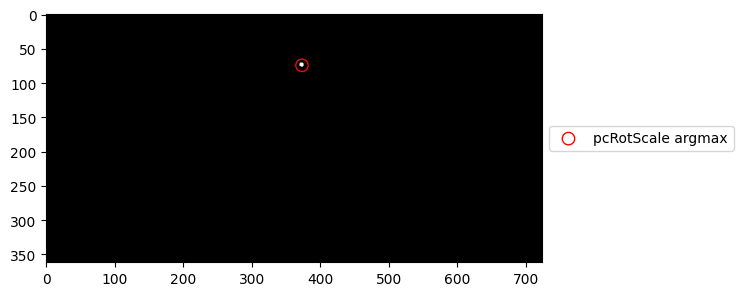

1


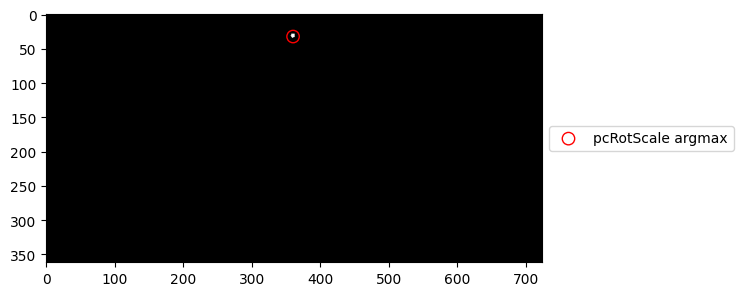

2


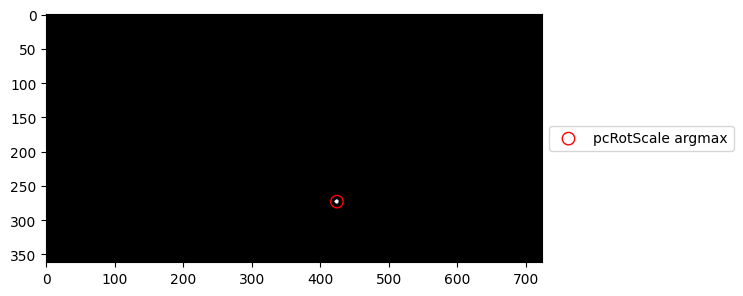

3


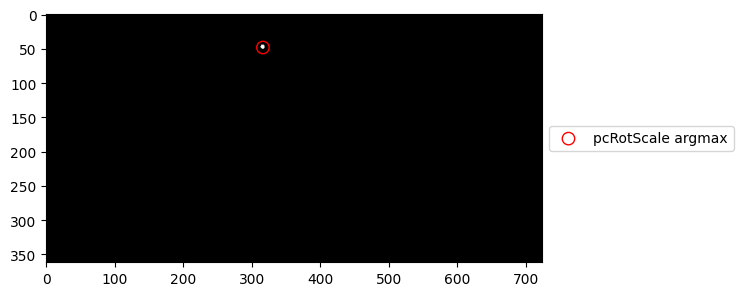

4


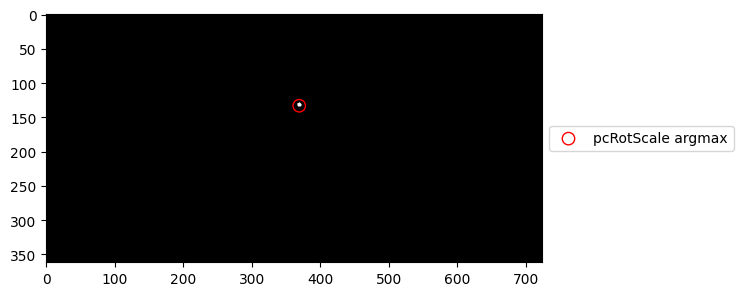

5


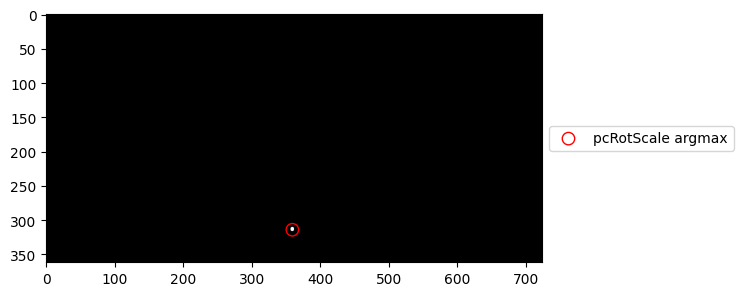

6


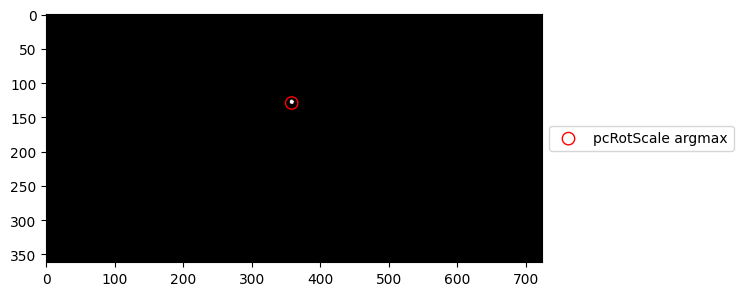

7


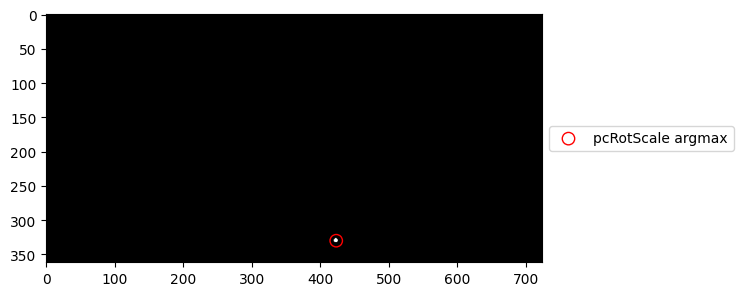

8


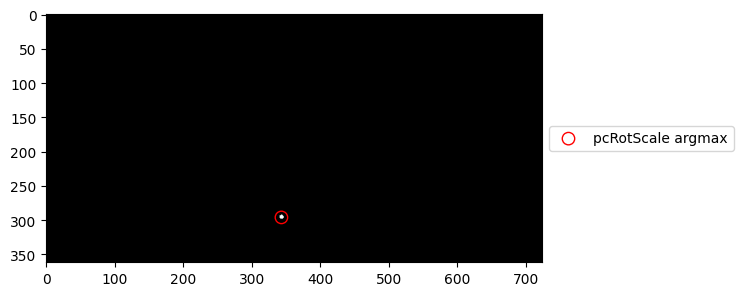

9


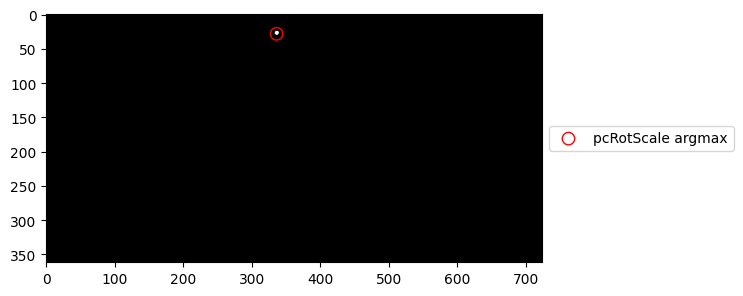

10


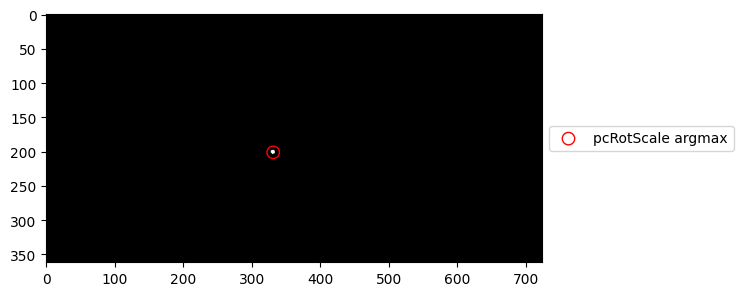

11


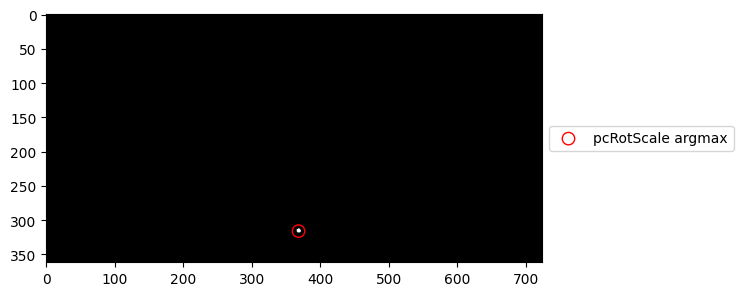

12


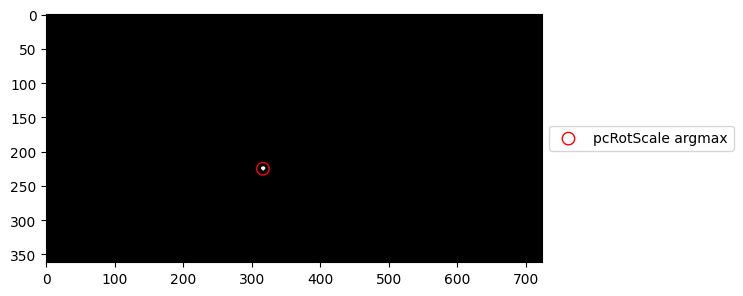

13


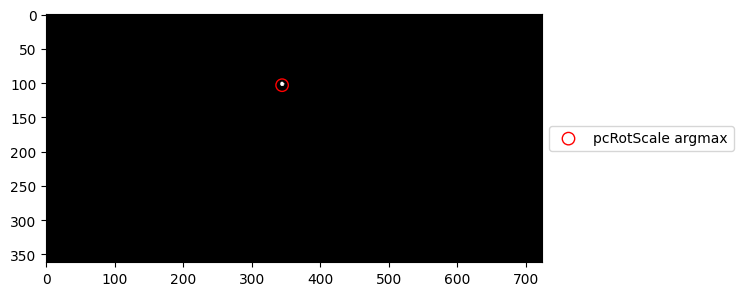

14


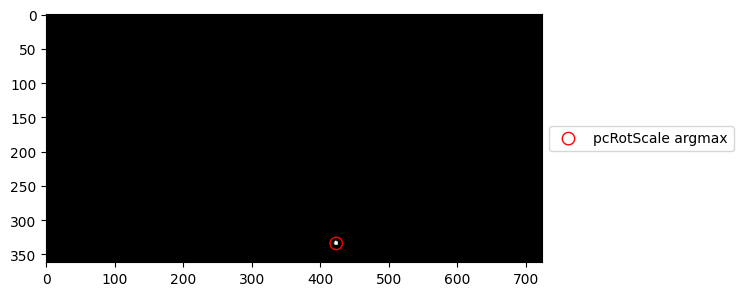

In [6]:
import numpy as np
import matplotlib.pyplot as plt
rotY = (-((gtAngle-90)/360 *mf.logPolar.angular_space_length ) )
radius = mf.logPolar.get_radius()
scaleX = (ans["params"]["pcRotScale"].size(-1) // 2) - (radius * torch.log(gtScale) / math.log(radius))
rotScaleH, rotScaleW = ans["params"]["pcRotScale"].shape[-2:]
r=3
for b in range(ijPred.shape[0]):
    print(b)
    arr2 = ans["params"]["pcRotScale"][b]
    mask = mf.get_rotscale_disk(rotScaleH, rotScaleW, gtAngle, gtScale, r)
    y2, x2 = np.unravel_index(np.argmax(arr2), arr2.shape)
    plt.imshow(mask[b], cmap="gray")   # background
    plt.scatter(x2, y2, s=80, facecolors='none', edgecolors='r', linewidths=1, label="pcRotScale argmax")  # thicker
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


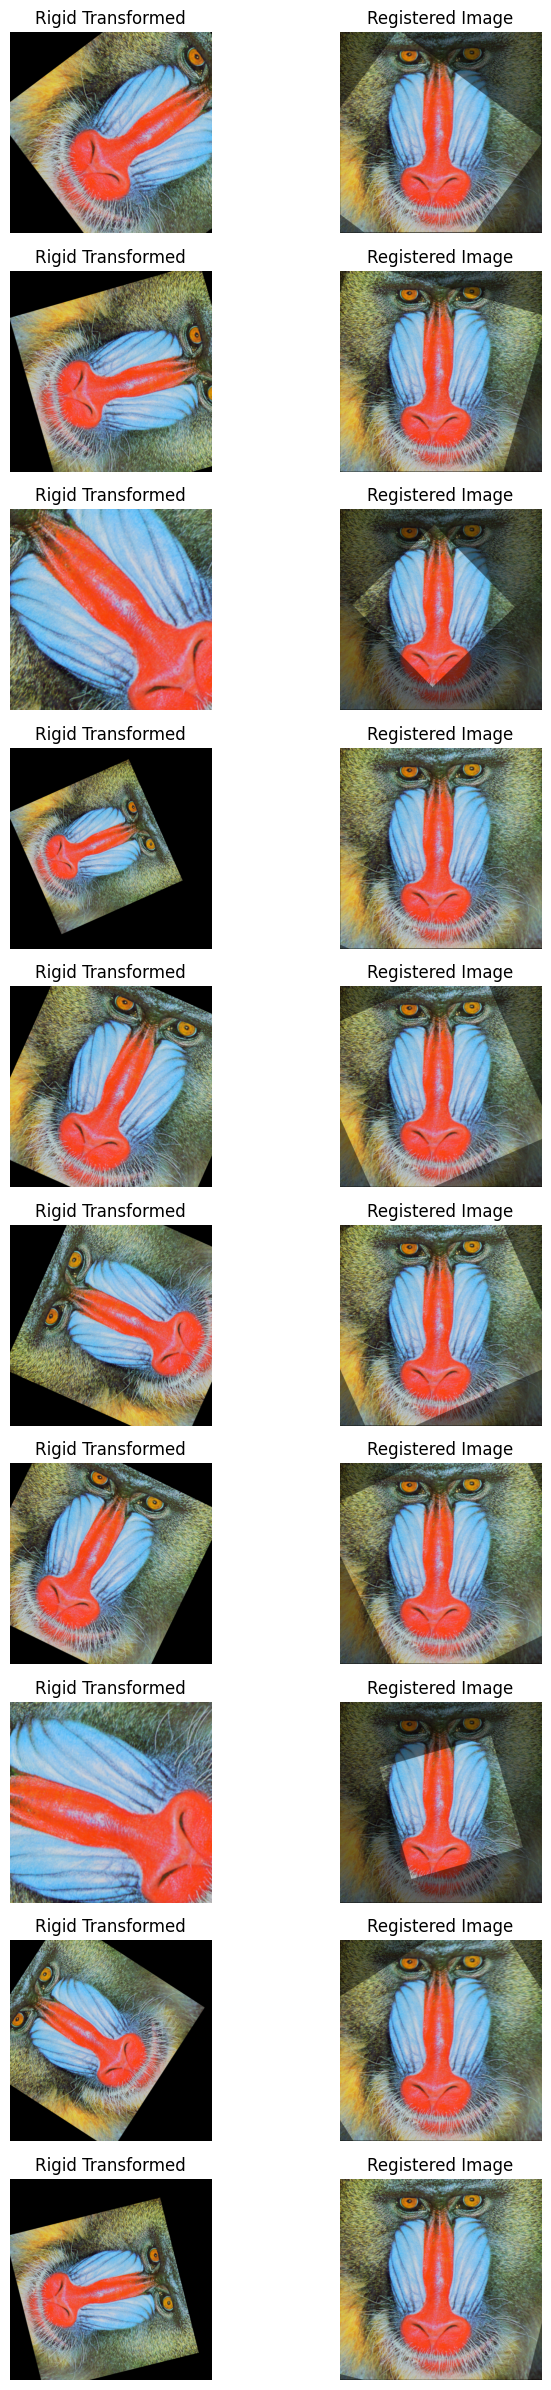

In [7]:

fig, axs = plt.subplots(10, 2, figsize=(8, 24))
for i in range(10):
    axs[i, 0].imshow(bimageTransf[i].moveaxis(0,-1))
    axs[i, 0].set_title('Rigid Transformed')
    axs[i, 0].axis('off')
    axs[i, 1].imshow(imageTransfRegistered[i].moveaxis(0,-1))
    axs[i, 1].set_title('Registered Image')
    axs[i, 1].imshow(bimage[i].moveaxis(0,-1), alpha=0.5)
    axs[i, 1].axis('off')
plt.tight_layout()
plt.show()